### Control Parameters 

In [1]:
import datetime
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump, load

In [2]:
## parameters
exp_index = [
            'coil',
            'coil_double',
            'coil_reverse',
            'coil_reverse_double',
            'coil_down',
            'coil_reverse_down',
            'square_double',
#             'manual',
#             'manual_wind',
#             'coil_reverse_double_wind',
#             'coil_double_wind',
#             'squre_double_wind'
            ]

data_folder_path = './blimpSim/data'
results_path = './blimpSim/results'

## Convert rosbag to csv
bool_convert_rosbag2csv = False

    # *******************************************

## Load csv files
class Msg_structure:
    def __init__(self, name=None, feature_list=None, feature_rename_list=None):
        self.name = name
        self.feature_list = feature_list
        self.feature_rename_list = feature_rename_list


speed_msg = Msg_structure(name = 'ground_speed', 
                          feature_list = ['Time',
                              'twist.linear.x','twist.linear.y','twist.linear.z',
                              'twist.angular.x','twist.angular.y','twist.angular.z'], 
                          feature_rename_list = ['Time',
                              'velocity.linear.x','velocity.linear.y','velocity.linear.z',
                              'velocity.angular.x','velocity.angular.y','velocity.angular.z']
                         )
position_msg = Msg_structure(name = 'ground_truth-position', 
                             feature_list =  ['Time','point.x','point.y','point.z'], 
                             feature_rename_list = ['Time', 'positoin.x', 'position.y', 'position.z'])
imu_msg = Msg_structure(name = 'ground_truth-imu',
                        feature_list = ['Time','orientation.x','orientation.y','orientation.z','orientation.w',
                                        'angular_velocity.x','angular_velocity.y','angular_velocity.z',
                                        'linear_acceleration.x','linear_acceleration.y','linear_acceleration.z'],
                        feature_rename_list = ['Time', 'imu.orientation.x','imu.orientation.y','imu.orientation.z','imu.orientation.w',
                                               'imu.angular_velocity.x','imu.angular_velocity.y','imu.angular_velocity.z',
                                               'imu.linear_acceleration.x','imu.linear_acceleration.y','imu.linear_acceleration.z'])
tail_imu_msg = Msg_structure(name = 'tail-imu',
                            feature_list = ['Time','orientation.x','orientation.y','orientation.z','orientation.w',
                                            'angular_velocity.x','angular_velocity.y','angular_velocity.z',
                                            'linear_acceleration.x','linear_acceleration.y','linear_acceleration.z'],
                            feature_rename_list = ['Time', 'tail_imu.orientation.x','tail_imu.orientation.y','tail_imu.orientation.z','tail_imu.orientation.w',
                                                   'tail_imu.angular_velocity.x','tail_imu.angular_velocity.y','tail_imu.angular_velocity.z',
                                                   'tail_imu.linear_acceleration.x','tail_imu.linear_acceleration.y','tail_imu.linear_acceleration.z'])
tail_position_msg = Msg_structure(name = 'tail-position', 
                                 feature_list =  ['Time','point.x','point.y','point.z'], 
                                 feature_rename_list = ['Time', 'tail.positoin.x', 'tail.position.y', 'tail.position.z'])
autopilotInfo_msg = Msg_structure(name = 'AutopilotInfo',
                              feature_list = ['Time','VelocityDesired.x','VelocityDesired.y','VelocityDesired.z'],
                              feature_rename_list = ['Time','target.velocity.x','target.velocity.y','target.velocity.z']
                             )                                        
                             
obs_msg = [
    speed_msg,
#     position_msg,
    imu_msg,
#     tail_imu_msg,
#     tail_position_msg,
    autopilotInfo_msg
]

    # *******************************************

actuator_msg = Msg_structure(name = 'GCSACTUATORS',
                            feature_list = ['Time', 'data.data'],
                            feature_rename_list = ['Time', 'm2','lfin','rfin','tfin','bfin','stick','m1','unused0', 'm0', 'unused1','unused2','unused3'])

act_msg = [actuator_msg]

all_msg = obs_msg + act_msg

    # *******************************************

noise_level = 0.2
pseudo_target_min = np.array([-5.5, -5.5, -1.2])
pseudo_target_max = np.array([5.5, 5.5, 1.2])
pseudo_target_name_list = autopilotInfo_msg.feature_rename_list
pseudo_target_features_num = len(pseudo_target_name_list)-1

obs_feature_list =  [msg.feature_rename_list for msg in obs_msg ]
act_feature_list =  [msg.feature_rename_list for msg in act_msg ]

time_feature_name = 'Time'
purge_feature_list=[]
purge_feature_list.append(time_feature_name)

## Data processing
act_filter_feature = ['m2','lfin','rfin','tfin','bfin','stick','m1','unused0', 'm0', 'unused1','unused2','unused3']
train_test_split_ratio = (0.9,0.1)
act_scale_bnd = {'act_max':2000,
                 'act_min':1000,
                 'scaled_act_max':1,
                 'scaled_act_min':-1,
                }
bool_round = True
rounding_factor = 2

## Define Reward Function
target_feature_list = ['target.velocity.x', 'target.velocity.y', 'target.velocity.z']
obsCost_feature_list = ['velocity.linear.x','velocity.linear.y','velocity.linear.z']
actCost_feature_list = ['m0','m1','m2']
actChangeCost_feature_list = ['m0','m1','m2','stick','tfin','bfin','lfin','rfin']
reward_weights = (1, 0, 0) #(0.2,1,1)

## Create parameter dics
params = {
    "exp_index":exp_index,
    "data_folder_path":data_folder_path,
    "results_path":results_path,
    
    "bool_convert_rosbag2csv":bool_convert_rosbag2csv,
    
    "all_msg":all_msg,
    "obs_msg":obs_msg,    
    "act_msg":act_msg,

    "pseudo_target_name_list":pseudo_target_name_list,
    "noise_level":noise_level,
    "pseudo_target_features_num":pseudo_target_features_num,
    "pseudo_target_min":pseudo_target_min,
    "pseudo_target_max":pseudo_target_max,
    
    "target_feature_list":target_feature_list,
    "obs_feature_list":obs_feature_list,
    "act_feature_list":act_feature_list,
    "time_feature_name":time_feature_name,
    "purge_feature_list":purge_feature_list,
    
    "train_test_split_ratio":train_test_split_ratio,
    "act_filter_feature":act_filter_feature,
    'act_scale_bnd':act_scale_bnd,
    "bool_round":bool_round,
    "rounding_factor":rounding_factor,
    
    "obsCost_feature_list":obsCost_feature_list,
    "actCost_feature_list":actCost_feature_list,
    "actChangeCost_feature_list":actChangeCost_feature_list,
    "reward_weights":reward_weights,
    
}

### Convert rosbag to csv

In [3]:
if params["bool_convert_rosbag2csv"]:    
    import bagpy
    from bagpy import bagreader
    
    class ConvertBag2csv: 
        def __init__(self):
            pass

        def rosbag2csv(self,rosbag_path):
            b = bagreader(rosbag_path)
            csvfiles = []
            for t in b.topics:
                data = b.message_by_topic(t)
                csvfiles.append(data)

        def convert_rosbag2csv(self,directory):
            for root,dirs,files in os.walk(directory):
                for file in files:
                    if file.endswith(".bag"):
                        path = os.path.join(root,file)
                        self.rosbag2csv(path)
                        print(f'bag: {file} convert to csv')
        
    print(f'data_folder_path: {data_folder_path}')
    clsConvertBag2csv = ConvertBag2csv()
    
    print(f'----------Start Converting Rosbag to CSV files----------')
    clsConvertBag2csv.convert_rosbag2csv(data_folder_path)
    print(f'----------Finish Convert----------')

### Load data from csv files

In [4]:
class objTransitions:
    def __init__(self, df=None, *params):
        self.df = df
        self.params = params

        self.time = None
        self.act = None
        self.next_act = None
        self.obs = None
        self.next_obs = None
        self.delta_obs = None
        
        self.len = 0
        
        if (df is not None):
            self.update(df, params)
        
    def update(self, df, *params):
        self.time = self.get_time(df,params)
        self.act, self.obs, self.next_act, self.next_obs = self.split_act_obs(df, params)
        self.delta_obs = self.calculate_delta_obs(self.obs, self.next_obs)
        self.len = len(self.df.index)-1
    
    def calculate_delta_obs(self, obs, next_obs):
        return next_obs - obs
    
    def split_act_obs(self, df, *params):
        act_obs, next_act_obs = df[:-1], df[1:]
        next_act_obs = next_act_obs.reset_index(drop=True)
        
        act = act_obs[self.flatten_list(act_feature_list)]
        obs = act_obs[self.flatten_list(obs_feature_list)]
        next_act = next_act_obs[self.flatten_list(act_feature_list)]
        next_obs = next_act_obs[self.flatten_list(obs_feature_list)]
        
        act = self.purge_feature(act, params)
        obs = self.purge_feature(obs, params)
        next_act = self.purge_feature(next_act, params)
        next_obs = self.purge_feature(next_obs, params)
        
        return act, obs, next_act, next_obs
    
    def flatten_list(self, alist):
        flatten_list = [item for sublist in alist for item in sublist]
        return flatten_list

    def purge_feature(self, df, *params):
        try:
            df=df.drop(purge_feature_list, axis=1)
        except:
            pass
        return df
    
    def reset_index(self):
        self.df.reset_index(drop=True, inplace=True)
        self.act.reset_index(drop=True, inplace=True)
        self.next_act.reset_index(drop=True, inplace=True)
        self.obs.reset_index(drop=True, inplace=True)
        self.next_obs.reset_index(drop=True, inplace=True)
        self.delta_obs.reset_index(drop=True, inplace=True)
        
    def concat_objData(self, new_objData):
        self.df = self.concat_df(self.df, new_objData.df)
        self.update(self.df, self.params)
    
    def concat_df(self, df, df_new):
        if df is None:
            return df_new
        else:
            df = pd.concat([df, df_new], axis=0, ignore_index=True)
        return df
    
    def get_time(self, df, *params):
        return df[time_feature_name]

In [5]:
class Load_data:
    def __init__(self):
        pass

    def load_csv_index(self, directory):
        csv_index=[]
        for root,dirs,files in os.walk(directory):
            for file in files:
                if file.endswith(".csv"):
                    path = os.path.join(root,file)
                    csv_index.append(path)
        return csv_index
    
    # *******************************************
    
    def create_df_from_csvIndex(self, csv_index, *params):
        df_list = self.read_csvfiles(csv_index, params)
        df = self.merge_df_list(df_list)
        df.sort_values(by='Time', inplace=True)
        return df
    
    def read_csvfiles(self, csv_index, *params):
        df_list=[]

        for msg in all_msg:
            if (msg.name=="AutopilotInfo") and self.AutopilotInfo_csv_not_exist(csv_index):
                time_df = df['Time']
                df = self.generate_fake_AutopilotInfo(time_df, params)
                df_list.append(df)     
            else:
                df = self.create_df(csv_index, 
                                    msg.name, 
                                    msg.feature_list, 
                                    msg.feature_rename_list,
                                    params)
                df_list.append(df)    
            
        return df_list
    
    def create_df(self, csv_index, msg_name, feature_list, feature_rename_list, *params):
        df = self.read_df_from_msg_in_csvIndex(csv_index, msg_name, params)
        df = df[feature_list]
        df = self.unwrap_features(df)
        df.columns = feature_rename_list
        return df    
    
    def read_df_from_msg_in_csvIndex(self, csv_index, msg_name, params):
        for csv_name in csv_index:
            if msg_name in csv_name:
                df = pd.read_csv(csv_name)
        return df
    
    # *******************************************
    
    def unwrap_features(self, df):
        for col_name in df.columns:
            col = df[col_name]
            col_data_type = self.check_col_data_type(col)
            
            if col_data_type == tuple:
                df = self.unwrap_tuple_feature(df, col_name)
                
        return df
            
    def check_col_data_type(self, col):
        first_element = col[0]
        data_type = type(first_element)
        
        if data_type == str:
            col = col.map(lambda x:eval(x))
            first_element = col[0]
            data_type = type(first_element)
        
        return data_type
    
    def unwrap_tuple_feature(self, df, col_name):
        tuple_col = df.pop(col_name)
        tuple_col = tuple_col.map(lambda x:eval(x))
        
        first_element = tuple_col[0]
        feature_len = len(first_element)
        
        feature_list = []
        for i in range(feature_len):
            new_feature = tuple_col.str[i]
            feature_list.append(new_feature)
            
        feature_pd = pd.concat(feature_list, axis=1)
        df = pd.concat([df, feature_pd], axis=1)
        
        return df
    
    # *******************************************
    
    def merge_df_list(self, df_list):
        df = df_list[0]
        iter_data = iter(df_list)
        next(iter_data)
        for item in iter_data:
            df = pd.merge(df, item, how='left')
        return df
    
    # *******************************************

    def AutopilotInfo_csv_not_exist(self, csv_index):
        l = [csv_name for csv_name in csv_index if "AutopilotInfo" in csv_name]
        if (len(l) == 0):
            return True
        else:
            return False
            
    def generate_fake_AutopilotInfo(self, time_df, *params):
        time_len = len(time_df.index)
        pseudo_target_shape = (time_len, pseudo_target_features_num)
        pseudo_target_df = self.generate_pseudo_target(pseudo_target_shape, params)
        df = pd.concat([time_df, pseudo_target_df], axis=1)
        df.columns = pseudo_target_name_list
        return df
    
    def generate_pseudo_target(self, pseudo_target_shape, *params):
        target_noise = noise_level * np.random.normal(pseudo_target_min, pseudo_target_max, pseudo_target_shape)
        pseudo_target_df = pd.DataFrame(target_noise)
        return pseudo_target_df

    # *******************************************
    
    def main(self, *params):
        objData = objTransitions()

        for exp in exp_index: 
            exp_path = os.path.join(data_folder_path, exp)

            print('[ LOAD csv ]', exp)
            csv_index = self.load_csv_index(exp_path)
            
            print('[ CREATE df ] start',csv_index)
            df = self.create_df_from_csvIndex(csv_index, params)
    
            print('[ CREATE objData ] start')
            new_objData = objTransitions(df, params)
        
            print('[ CONCAT objData ] start')
            objData.concat_objData(new_objData)

        print('[ RESET Index ] start')
        objData.reset_index()

        print('[ LOAD csv ] Complete')
        return objData

In [6]:
clsLoadData = Load_data()
objData = clsLoadData.main(params)

[ LOAD csv ] coil
[ CREATE df ] start ['./blimpSim/data/coil/blimp-tail-position.csv', './blimpSim/data/coil/blimp-stick_joint_position_controller-command.csv', './blimpSim/data/coil/blimp-TransmitterInfo.csv', './blimpSim/data/coil/blimp-botfin_joint_position_controller-command.csv', './blimpSim/data/coil/blimp-rightfin_joint_position_controller-command.csv', './blimpSim/data/coil/blimp-motor_speed-2.csv', './blimpSim/data/coil/blimp-command-motor_speed.csv', './blimpSim/data/coil/blimp-octoPose.csv', './blimpSim/data/coil/blimp-ground_truth-imu.csv', './blimpSim/data/coil/blimp-tail-pose.csv', './blimpSim/data/coil/blimp-motor_speed-1.csv', './blimpSim/data/coil/blimp-GCSACTUATORS.csv', './blimpSim/data/coil/blimp-Octocopter.csv', './blimpSim/data/coil/blimp-motor_speed-0.csv', './blimpSim/data/coil/blimp-AutopilotInfo.csv', './blimpSim/data/coil/blimp-ground_speed.csv', './blimpSim/data/coil/blimp-tail-imu.csv', './blimpSim/data/coil/blimp-ground_truth-pose.csv', './blimpSim/data/co

In [7]:
objData.act

,m2,lfin,rfin,tfin,bfin,stick,m1,unused0,m0,unused1,unused2,unused3
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
620090,1909.0,1581.0,1581.0,1909.0,1909.0,1143.0,1684.0,1000.0,1684.0,1000.0,1000.0,1000.0
620091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
620092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
620093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
objData.obs

,velocity.linear.x,velocity.linear.y,velocity.linear.z,velocity.angular.x,velocity.angular.y,velocity.angular.z,imu.orientation.x,imu.orientation.y,imu.orientation.z,imu.orientation.w,imu.angular_velocity.x,imu.angular_velocity.y,imu.angular_velocity.z,imu.linear_acceleration.x,imu.linear_acceleration.y,imu.linear_acceleration.z,target.velocity.x,target.velocity.y,target.velocity.z
0,-1.274322,3.141912,0.113986,0.0,0.0,0.0,-0.034027,-0.004498,0.862175,0.505446,0.002714,0.066698,0.102039,-0.511604,-0.045479,9.596631,NaN,NaN,NaN
1,-1.276449,3.140842,0.112771,0.0,0.0,0.0,-0.034168,-0.004399,0.862299,0.505226,0.002638,0.066654,0.102255,-0.515122,-0.034597,9.596564,NaN,NaN,NaN
2,-1.278567,3.139777,0.111557,0.0,0.0,0.0,-0.034309,-0.004301,0.862422,0.505008,0.002621,0.066602,0.101611,-0.518639,-0.045250,9.596498,NaN,NaN,NaN
3,-1.280673,3.138714,0.110344,0.0,0.0,0.0,-0.034449,-0.004202,0.862544,0.504790,0.002546,0.066540,0.101837,-0.522119,-0.034402,9.596424,NaN,NaN,NaN
4,-1.282765,3.137655,0.109132,0.0,0.0,0.0,-0.034590,-0.004103,0.862666,0.504572,0.002527,0.066477,0.101203,-0.525601,-0.045066,9.596347,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620090,-1.251230,1.568397,-0.004093,0.0,0.0,0.0,-0.006636,0.031689,-0.990987,-0.129986,0.028853,-0.019559,0.295120,0.193564,-0.183832,9.817567,NaN,NaN,NaN
620091,-1.252581,1.566705,-0.004424,0.0,0.0,0.0,-0.006671,0.031630,-0.991085,-0.129248,0.028835,-0.019676,0.295632,0.194683,-0.171059,9.817071,NaN,NaN,NaN
620092,-1.253941,1.564976,-0.004753,0.0,0.0,0.0,-0.006707,0.031571,-0.991183,-0.128512,0.028789,-0.019796,0.295127,0.195751,-0.183138,9.816625,NaN,NaN,NaN
620093,-1.255311,1.563258,-0.005082,0.0,0.0,0.0,-0.006742,0.031512,-0.991280,-0.127775,0.028768,-0.019909,0.295663,0.196860,-0.170166,9.816188,NaN,NaN,NaN


### Data processing

In [9]:
class Data_processing:
    def __init__(self):
        pass
    
    def fill_objData_NA(self, objData):
        objData.df = self.fill_df_NA(objData.df)
        objData.act = self.fill_df_NA(objData.act)
        objData.next_act = self.fill_df_NA(objData.next_act)
        objData.obs = self.fill_df_NA(objData.obs)
        objData.next_obs = self.fill_df_NA(objData.next_obs)
        objData.delta_obs = self.fill_df_NA(objData.delta_obs)
        
        return objData
    
    def fill_df_NA(self, df):
        df = df.fillna(method='ffill')
        df = df.fillna(0)
        return df
    
    # *******************************************
    def clean_error_data(self, objData, *params):
        objData = self.change_targetVelocity_frame_NED2ENU(objData)
        objData = self.clean_act_error_row(objData, params)
        return objData
    
    def clean_act_error_row(self, objData, *params):
        df = objData.df
        act = objData.act
        act_min = act_scale_bnd['act_min']
        for filter_feature in act_filter_feature:
            df = df[ df[filter_feature] >= act_min ]
        df.reset_index(drop=True, inplace=True)
        new_objData = objTransitions(df, params)
        return new_objData
    
    def change_targetVelocity_frame_NED2ENU(self, objData, *params):
        df = objData.df
        x = target_feature_list[0]
        y = target_feature_list[1]
        z = target_feature_list[2]
        df = df.rename(columns={x:y, y:x})
        df[z] = -df[z]
        new_objData = objTransitions(df, params)
        return new_objData
    
    # *******************************************

    def split_trainTest_objData(self, objData, *params):
        idx = self.get_trainTest_index(objData.len, train_test_split_ratio)
        objData_train, objData_test = self.split_objData(objData, idx, params)
        
        return objData_train, objData_test
        
    def split_objData(self, objData, idx, *params):
        df_train, df_test = self.split_df(objData.df, idx)
        objData_train = objTransitions(df_train, params)
        objData_test = objTransitions(df_test, params)
        
        return objData_train, objData_test

    def split_df(self, df, idx):
        idx_train, idx_test = idx
        df_train, df_test = df.loc[idx_train], df.loc[idx_test]
        df_train=df_train.reset_index(drop=True)
        df_test=df_test.reset_index(drop=True)
        return df_train, df_test
    
    def get_trainTest_index(self, n_data, ratio):
        ratio_train, ratio_test = ratio
        n_train = int(n_data*ratio_train)
        n_test = n_data - n_train 

        idx_randperm = np.random.permutation(n_data-1)
        idx_train = np.sort(idx_randperm[:n_train])
        idx_test = np.sort(idx_randperm[n_train+1:])
        return (idx_train, idx_test)
    
    # *******************************************
    
    def data_processsing(self, objData_train, objData_test, *params):
        objData_train = self.scale_objData_act(objData_train, params)
        objData_test = self.scale_objData_act(objData_test, params)
        
        if bool_round:
            objData_train = self.round_objData(objData_train, params)
            objData_test = self.round_objData(objData_test, params)
        
        return objData_train, objData_test
    
    def scale_objData_act(self, objData, *params):
        act_max, act_min = act_scale_bnd['act_max'],  act_scale_bnd['act_min']
        scaled_act_max, scaled_act_min = act_scale_bnd['scaled_act_max'], act_scale_bnd['scaled_act_min']
        
        objData.act = self.minmax_scale_df(objData.act, act_max, act_min, scaled_act_max, scaled_act_min)
        objData.next_act = self.minmax_scale_df(objData.next_act, act_max, act_min, scaled_act_max, scaled_act_min)
        
        return objData
    
    def minmax_scale_df(self, df, df_max, df_min, target_max, target_min):
        df_mean = ( df_max + df_min) / 2 
        target_mean = ( target_max + target_min ) / 2
        
        scale = ( df_max - df_min ) / (target_max - target_min) 
        df = ( df - df_mean ) / scale + target_mean
        return df
    
    
    def round_objData(self, objData, *params):
        objData.act = objData.act.round(rounding_factor)
        objData.next_act = objData.next_act.round(rounding_factor)
        objData.obs = objData.obs.round(rounding_factor)
        objData.next_obs = objData.next_obs.round(rounding_factor)
        objData.delta_obs = objData.delta_obs.round(rounding_factor)
        return objData

    # *******************************************

    def main(self, objData, *params):
        print("[ Data processing ] Fill NA ")
        objData = self.fill_objData_NA(objData)
        
        print("[ Data processing ] Clean Error Data")
        objData = self.clean_error_data(objData, params)

        print("[ Data processing ] Split train and test data ")
        objData_train, objData_test = self.split_trainTest_objData(objData, params)
        
        print("[ Data processing ] Scale action data, Round data ")
        objData_train, objData_test = self.data_processsing(objData_train, objData_test, params)
        
        print('[ Data processing ] Complete')
        return objData_train, objData_test
        

In [10]:
clsDataProcessing = Data_processing()
objData_train, objData_test = clsDataProcessing.main(objData, params)

[ Data processing ] Fill NA 
[ Data processing ] Clean Error Data
[ Data processing ] Split train and test data 
[ Data processing ] Scale action data, Round data 
[ Data processing ] Complete


In [11]:
objData_train.act.min()

m2        -0.99
lfin      -0.99
rfin      -0.99
tfin      -0.99
bfin      -0.99
stick     -0.99
m1         0.09
unused0   -1.00
m0         0.09
unused1   -1.00
unused2   -1.00
unused3   -1.00
dtype: float64

In [12]:
objData_test.obs

,velocity.linear.x,velocity.linear.y,velocity.linear.z,velocity.angular.x,velocity.angular.y,velocity.angular.z,imu.orientation.x,imu.orientation.y,imu.orientation.z,imu.orientation.w,imu.angular_velocity.x,imu.angular_velocity.y,imu.angular_velocity.z,imu.linear_acceleration.x,imu.linear_acceleration.y,imu.linear_acceleration.z,target.velocity.x,target.velocity.y,target.velocity.z
0,-1.30,3.13,0.10,0.0,0.0,0.0,-0.04,-0.00,0.86,0.50,0.00,0.07,0.10,-0.55,-0.03,9.60,0.00,0.00,-0.00
1,-1.30,3.13,0.10,0.0,0.0,0.0,-0.04,-0.00,0.86,0.50,0.00,0.07,0.10,-0.55,-0.04,9.60,0.00,0.00,-0.00
2,-1.33,3.11,0.08,0.0,0.0,0.0,-0.04,-0.00,0.87,0.50,0.00,0.06,0.10,-0.60,-0.04,9.59,0.00,0.00,-0.00
3,-1.34,3.11,0.08,0.0,0.0,0.0,-0.04,-0.00,0.87,0.50,0.00,0.06,0.10,-0.62,-0.05,9.59,0.00,0.00,-0.00
4,-1.42,3.06,0.02,0.0,0.0,0.0,-0.04,0.00,0.87,0.49,0.00,0.06,0.09,-0.76,-0.04,9.59,-1.94,-0.88,-1.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62001,-1.18,1.66,0.01,0.0,0.0,0.0,-0.01,0.04,-0.98,-0.17,0.03,-0.01,0.29,0.16,-0.23,9.80,2.00,0.01,0.04
62002,-1.18,1.66,0.01,0.0,0.0,0.0,-0.01,0.04,-0.98,-0.17,0.03,-0.01,0.29,0.16,-0.22,9.80,2.00,0.01,0.04
62003,-1.20,1.63,0.01,0.0,0.0,0.0,-0.01,0.03,-0.99,-0.16,0.03,-0.02,0.29,0.17,-0.20,9.81,2.00,0.01,0.04
62004,-1.21,1.61,0.01,0.0,0.0,0.0,-0.01,0.03,-0.99,-0.15,0.03,-0.02,0.29,0.18,-0.19,9.80,2.00,0.01,0.04


In [25]:
objData_train.act

,m2,lfin,rfin,tfin,bfin,stick,m1,unused0,m0,unused1,unused2,unused3
0,0.16,-0.85,-0.85,0.16,0.16,-0.99,0.46,-1.0,0.46,-1.0,-1.0,-1.0
1,0.16,-0.85,-0.85,0.16,0.16,-0.99,0.46,-1.0,0.46,-1.0,-1.0,-1.0
2,0.16,-0.85,-0.85,0.16,0.16,-0.99,0.46,-1.0,0.46,-1.0,-1.0,-1.0
3,0.16,-0.85,-0.85,0.16,0.16,-0.99,0.46,-1.0,0.46,-1.0,-1.0,-1.0
4,0.16,-0.85,-0.85,0.16,0.16,-0.99,0.46,-1.0,0.46,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
558073,0.82,0.17,0.17,0.82,0.82,-0.71,0.37,-1.0,0.37,-1.0,-1.0,-1.0
558074,0.82,0.17,0.17,0.82,0.82,-0.71,0.37,-1.0,0.37,-1.0,-1.0,-1.0
558075,0.82,0.16,0.16,0.82,0.82,-0.71,0.37,-1.0,0.37,-1.0,-1.0,-1.0
558076,0.82,0.16,0.16,0.82,0.82,-0.71,0.37,-1.0,0.37,-1.0,-1.0,-1.0


### Define Reward Function

In [14]:
class Define_rewardFn():
    def __init__(self):
        pass
 
    def reward_fn(self, objData, *params):
        obs_df = objData.obs
        act_df = objData.act
        next_act_df = objData.next_act
        
        obs_target_df = obs_df [ target_feature_list ]
        obs_cost_df = obs_df[ obsCost_feature_list ]
        
        obsCost_np = reward_weights[0]*self.calculate_obsCost(obs_cost_df, obs_target_df, params)
        actCost_np = reward_weights[1]*self.calculate_actCost(act_df, params)
        actChangeCost_np = reward_weights[2]*self.calculate_actChangeCost(act_df, next_act_df, params)
        
        rewards = obsCost_np + actCost_np + actChangeCost_np
        
        info = pd.DataFrame({'obsCost':obsCost_np, 'actCost':actCost_np, 'actChangeCost':actChangeCost_np})
        rewards = pd.DataFrame({'rewards':rewards})
        return rewards, info
    
    def calculate_obsCost(self, obs_df, obs_target_df, *params):
        obsCost_np = obs_target_df.to_numpy()  - obs_df.to_numpy() 
        obsCost_np = -np.linalg.norm(obsCost_np, axis=1)
        return obsCost_np
    
    def calculate_actCost(self, act_df, *params):
        actCost_np = act_df[ actCost_feature_list ].to_numpy()
        actCost_np = -np.linalg.norm(actCost_np, axis=1) 
        return actCost_np
    
    def calculate_actChangeCost(self, act_df, next_act_df, *params):
        actChangeCost_np = next_act_df[ actChangeCost_feature_list ].to_numpy() - act_df[ actChangeCost_feature_list ].to_numpy()
        actChangeCost_np = -np.linalg.norm(actChangeCost_np, axis=1) 
        return actChangeCost_np
    
    def split_xy(self, objData, rewards):
        x = pd.concat([objData.act, objData.obs], axis=1)
        y = pd.concat([rewards, objData.delta_obs], axis=1)
        return x, y
        
    def main(self, objData, *params):
        rewards, info = self.reward_fn(objData, params)
        x, y = self.split_xy(objData, rewards)
        
        return x, y, rewards, info


In [16]:
clsDefineRewardFn = Define_rewardFn()
x_train, y_train, rewards_train, info_train = clsDefineRewardFn.main(objData_train, params)
x_test, y_test, rewards_train, info_test = clsDefineRewardFn.main(objData_test, params)

array([[<AxesSubplot:title={'center':'obsCost'}>,
        <AxesSubplot:title={'center':'actCost'}>],
       [<AxesSubplot:title={'center':'actChangeCost'}>, <AxesSubplot:>]],
      dtype=object)

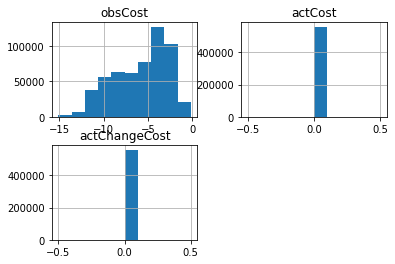

In [17]:
info_train.hist()

<AxesSubplot:>

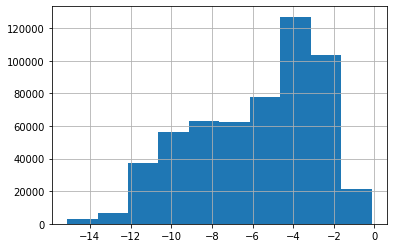

In [18]:
y_train.rewards.hist()

### Save data to csv

In [19]:
objData_train.obs.to_csv(os.path.join(results_path,'obs'), index=False)
objData_train.act.to_csv(os.path.join(results_path,'act'), index=False)
x_train.to_csv(os.path.join(results_path,'x_train'), index=False)
y_train.to_csv(os.path.join(results_path,'y_train'), index=False)
x_test.to_csv(os.path.join(results_path,'x_test'), index=False)
y_test.to_csv(os.path.join(results_path,'y_test'), index=False)

In [20]:
act_read_test = pd.read_csv(os.path.join(results_path,'act'))
obs_read_test = pd.read_csv(os.path.join(results_path,'obs'))

In [21]:
obs_read_test

,velocity.linear.x,velocity.linear.y,velocity.linear.z,velocity.angular.x,velocity.angular.y,velocity.angular.z,imu.orientation.x,imu.orientation.y,imu.orientation.z,imu.orientation.w,imu.angular_velocity.x,imu.angular_velocity.y,imu.angular_velocity.z,imu.linear_acceleration.x,imu.linear_acceleration.y,imu.linear_acceleration.z,target.velocity.x,target.velocity.y,target.velocity.z
0,-1.29,3.13,0.11,0.0,0.0,0.0,-0.04,-0.00,0.86,0.50,0.00,0.07,0.1,-0.54,-0.03,9.60,0.0,0.00,-0.00
1,-1.29,3.13,0.10,0.0,0.0,0.0,-0.04,-0.00,0.86,0.50,0.00,0.07,0.1,-0.54,-0.04,9.60,0.0,0.00,-0.00
2,-1.29,3.13,0.10,0.0,0.0,0.0,-0.04,-0.00,0.86,0.50,0.00,0.07,0.1,-0.54,-0.03,9.60,0.0,0.00,-0.00
3,-1.29,3.13,0.10,0.0,0.0,0.0,-0.04,-0.00,0.86,0.50,0.00,0.07,0.1,-0.55,-0.04,9.60,0.0,0.00,-0.00
4,-1.30,3.13,0.10,0.0,0.0,0.0,-0.04,-0.00,0.86,0.50,0.00,0.07,0.1,-0.56,-0.03,9.60,0.0,0.00,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558073,-1.25,1.57,-0.00,0.0,0.0,0.0,-0.01,0.03,-0.99,-0.13,0.03,-0.02,0.3,0.19,-0.18,9.82,2.0,0.01,0.04
558074,-1.25,1.57,-0.00,0.0,0.0,0.0,-0.01,0.03,-0.99,-0.13,0.03,-0.02,0.3,0.19,-0.17,9.82,2.0,0.01,0.04
558075,-1.25,1.57,-0.00,0.0,0.0,0.0,-0.01,0.03,-0.99,-0.13,0.03,-0.02,0.3,0.19,-0.18,9.82,2.0,0.01,0.04
558076,-1.25,1.57,-0.00,0.0,0.0,0.0,-0.01,0.03,-0.99,-0.13,0.03,-0.02,0.3,0.19,-0.17,9.82,2.0,0.01,0.04


In [22]:
act_read_test

,m2,lfin,rfin,tfin,bfin,stick,m1,unused0,m0,unused1,unused2,unused3
0,0.16,-0.85,-0.85,0.16,0.16,-0.99,0.46,-1.0,0.46,-1.0,-1.0,-1.0
1,0.16,-0.85,-0.85,0.16,0.16,-0.99,0.46,-1.0,0.46,-1.0,-1.0,-1.0
2,0.16,-0.85,-0.85,0.16,0.16,-0.99,0.46,-1.0,0.46,-1.0,-1.0,-1.0
3,0.16,-0.85,-0.85,0.16,0.16,-0.99,0.46,-1.0,0.46,-1.0,-1.0,-1.0
4,0.16,-0.85,-0.85,0.16,0.16,-0.99,0.46,-1.0,0.46,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
558073,0.82,0.17,0.17,0.82,0.82,-0.71,0.37,-1.0,0.37,-1.0,-1.0,-1.0
558074,0.82,0.17,0.17,0.82,0.82,-0.71,0.37,-1.0,0.37,-1.0,-1.0,-1.0
558075,0.82,0.16,0.16,0.82,0.82,-0.71,0.37,-1.0,0.37,-1.0,-1.0,-1.0
558076,0.82,0.16,0.16,0.82,0.82,-0.71,0.37,-1.0,0.37,-1.0,-1.0,-1.0


In [23]:
x_train

,m2,lfin,rfin,tfin,bfin,stick,m1,unused0,m0,unused1,...,imu.orientation.w,imu.angular_velocity.x,imu.angular_velocity.y,imu.angular_velocity.z,imu.linear_acceleration.x,imu.linear_acceleration.y,imu.linear_acceleration.z,target.velocity.x,target.velocity.y,target.velocity.z
0,0.16,-0.85,-0.85,0.16,0.16,-0.99,0.46,-1.0,0.46,-1.0,...,0.50,0.00,0.07,0.1,-0.54,-0.03,9.60,0.0,0.00,-0.00
1,0.16,-0.85,-0.85,0.16,0.16,-0.99,0.46,-1.0,0.46,-1.0,...,0.50,0.00,0.07,0.1,-0.54,-0.04,9.60,0.0,0.00,-0.00
2,0.16,-0.85,-0.85,0.16,0.16,-0.99,0.46,-1.0,0.46,-1.0,...,0.50,0.00,0.07,0.1,-0.54,-0.03,9.60,0.0,0.00,-0.00
3,0.16,-0.85,-0.85,0.16,0.16,-0.99,0.46,-1.0,0.46,-1.0,...,0.50,0.00,0.07,0.1,-0.55,-0.04,9.60,0.0,0.00,-0.00
4,0.16,-0.85,-0.85,0.16,0.16,-0.99,0.46,-1.0,0.46,-1.0,...,0.50,0.00,0.07,0.1,-0.56,-0.03,9.60,0.0,0.00,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558073,0.82,0.17,0.17,0.82,0.82,-0.71,0.37,-1.0,0.37,-1.0,...,-0.13,0.03,-0.02,0.3,0.19,-0.18,9.82,2.0,0.01,0.04
558074,0.82,0.17,0.17,0.82,0.82,-0.71,0.37,-1.0,0.37,-1.0,...,-0.13,0.03,-0.02,0.3,0.19,-0.17,9.82,2.0,0.01,0.04
558075,0.82,0.16,0.16,0.82,0.82,-0.71,0.37,-1.0,0.37,-1.0,...,-0.13,0.03,-0.02,0.3,0.19,-0.18,9.82,2.0,0.01,0.04
558076,0.82,0.16,0.16,0.82,0.82,-0.71,0.37,-1.0,0.37,-1.0,...,-0.13,0.03,-0.02,0.3,0.19,-0.17,9.82,2.0,0.01,0.04
